# import 

In [82]:
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import json, html, re
import numpy as np
from tqdm import tqdm
from glob import glob
from collections import Counter
from gensim.models import LdaModel
from gensim.corpora.dictionary import Dictionary
from datetime import timedelta, datetime
from pythainlp import word_tokenize
from pythainlp.corpus import thai_stopwords
STOPWORDS = thai_stopwords()

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
plt.style.use('ggplot')
font_path = '/Users/Nozomi/Library/Fonts/THSarabunNew.ttf'
font_label = fm.FontProperties(fname=font_path,weight='bold',size=25)

def clean(text, hashtag=None):
    if hashtag:
        text = text.replace(hashtag, '')
    text = html.unescape(text)
    text = re.sub(r'http.+?(?:\\s|$)', '', text) # URL link
    text = re.sub(r'[“”„]', '"', text) # convert double quotations into "
    text = re.sub(r'[‘’′′′′`]', "'", text) # convert single quotations into '
    text = re.sub(r'[ \u00a0\xa0\u3000\u2002-\u200a\t\n#]+', ' ', text) # shrink whitespaces e.g. good  boy -> good boy
    text = re.sub(r'[\r\u200b\ufeff]+', '', text) # remove non-breaking space
    text = re.sub(r'ํา','ำ', text) # am
    return text.strip()

def tokenize(text, hashtag=None):
    tokens = word_tokenize(clean(text, hashtag), keep_whitespace='False')
    tokens = [token for token in tokens if token not in STOPWORDS and re.match(r'[ก-๙][ก-๙\\.\\-]+$', token)]
    return tokens

def get_hour(row, string=True):
    date = datetime(row.date.year, row.date.month, row.date.day, int(row.time[:2]))
    if string:
        return str(date)[:-3] # '2021-04-09 22:00'
    else:
        return date # datetime.datetime(2021, 4, 9, 22, 0)
    
def timerange(df):
    oldest = get_hour(df.iloc[len(df)-1], False)
    latest = get_hour(df.iloc[0], False)
    range_list = [str(oldest)]
    while range_list[-1] != str(latest):
        oldest = oldest + timedelta(hours=1)
        range_list.append(str(oldest))
    return pd.DataFrame(range_list, columns=['date'])

In [13]:
!ls tweets

#16ตุลาไปแยกปทุมวัน.csv
#16ตุลาไปแยกปทุมวัน.json
#25พฤศจิกาไปSCB.csv
#25พฤศจิกาไปSCB.json
#saveวันเฉลิม.csv
#saveวันเฉลิม.json
#ม็อบ25พฤศจิกาทวงคืนสมบัติชาติ.csv
#ม็อบ25พฤศจิกาทวงคืนสมบัติชาติ.json
#ม็อบ2ธันวา.csv
#ม็อบ2ธันวา.json
#ธรรมศาสตร์และการชุมนุม.csv
#ธรรมศาสตร์และการชุมนุม.json
#กูสั่งให้มึงอยู่ใต้รัฐธรรมนูญ.csv
#เกียมอุดมไม่ก้มหัวให้เผด็จการ.csv
#กูสั่งให้มึงอยู่ใต้รัฐธรรมนูญ.json
#เกียมอุดมไม่ก้มหัวให้เผด็จการ.json
badstudent_tweet.json
freeyouth_tweet.csv
freeyouth_tweet.json
freeyouth_tweet_raw.csv


In [116]:
filename = 'tweets/freeyouth_tweet.json'
filename = 'tweets/badstudent_tweet.json'
filename = 'tweets/tanawatofficial_tweet.json'
num = 20

# frequent hashtag & cooccurent words

In [117]:
df = pd.read_json(filename, lines=True).drop_duplicates('id')
df = df.reset_index(drop=True)

### define duration ###
df = df[(df.date >= '2020-1-1') & (df.date <= '2020-12-31')]

### tokenize ###
df['tokens'] = df.tweet.apply(lambda x: tokenize(x))

##### hashtags #####
hashtag_counter = Counter()
for lst in df.hashtags:
    hashtag_counter.update(lst)
    
hashtag2word = {x[0]:Counter() for x in hashtag_counter.most_common(num)}

# count frequent words
for i, row in df.iterrows():
    for hashtag in row['hashtags']:
        if hashtag in hashtag2word:
            hashtag2word[hashtag].update(row['tokens'])
    
print("|hashtag|count|frequent words|oldest|popular|\n|:-:|:-:|:-:|:-:|:-:|")
for tag, c, in hashtag_counter.most_common(num):
    tempdf = df[df.hashtags.apply(lambda x: tag in x)].sort_values(['created_at'])
    
    ## frequent words
    freqs = " ".join([f"{w}({c})" for w,c in hashtag2word[tag].most_common(10)])
    
    ## oldest
    oldest = tempdf.iloc[0].tweet
    oldest_name = tempdf.iloc[0].username
    oldest_link = tempdf.iloc[0].link
    oldest_date = str(tempdf.iloc[0]['created_at']).split('+')[0]
    
    ## popular
    tempdf = tempdf.sort_values(["retweets_count"], ascending=False)
    popular = tempdf.iloc[0].tweet
    popular_name = tempdf.iloc[0].username
    popular_link = tempdf.iloc[0].link
    popular_date = str(tempdf.iloc[0]['created_at']).split('+')[0]
    retweet_count = tempdf.iloc[0].retweets_count
    
    print(f"|{tag}|{c}|{freqs}|[{oldest_date}]({oldest_link})<br>[@{oldest_name}](https://twitter.com/{oldest_name})<br><br>{oldest.replace('|||','')}|[{popular_date}]({popular_link})<br>[@{popular_name}](https://twitter.com/{popular_name})<br>{retweet_count} retweets<br><br>{popular.replace('|||','')}|")

|hashtag|count|frequent words|oldest|popular|
|:-:|:-:|:-:|:-:|:-:|
|ประชุมสภา|134|สภา(165) ประชุม(139) ส.ส.(43) ประชาชน(39) ม็อบ(39) คน(39) รัฐบาล(36) ประยุทธ์(33) ตุลา(28) รัฐ(15)|[2020-01-09 16:28:54](https://twitter.com/tanawatofficial/status/1215203786081234944)<br>[@tanawatofficial](https://twitter.com/tanawatofficial)<br><br>วันนี้บอลมายื่นหนังสือสือเชิญพรรคการเมืองฝ่ายค้าน มาร่วมงาน #วิ่งไล่ลุง เพื่อขับไล่ตัวถ่วงความเจริญของประเทศไปด้วยกัน  การแถลงข่าวของเราถูกสกัดจากตำรวจรัฐสภาอีกครั้ง ไม่ให้เข้าไปข้างใน เพียงเพราะเราใส่เสื้อวิ่งไล่ลุง เราขอยืนยันว่าการใส่เสื้อวิ่งไล่ลุงไม่ผิดกฎหมายครับ #ประชุมสภา  https://t.co/UvmLxCGxaT|[2020-06-10 22:19:57](https://twitter.com/tanawatofficial/status/1270737475451801603)<br>[@tanawatofficial](https://twitter.com/tanawatofficial)<br>27718 retweets<br><br>รายการ #แฉ เหมือนเอา #ปารีณา มาให้ #บุ๋มปนัดดา เชือด 55555  พรุ่งนี้เลิกสนใจนาง แล้วตาม #ประชุมสภา กันต่อนะครับ อย่าให้นางกลบกระแสการเมือง ที่ #รัฐบาลเฮงซวย กำลังจะทำ ได้สำเร็จ  https://t.co/

In [119]:
df = df.reset_index(drop=True)
df

,id,conversation_id,created_at,date,time,timezone,user_id,username,name,place,...,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest,tokens
0,1344570649285513216,1344570649285513216,2020-12-31 16:06:38+07:00,2020-12-31,16:06:38,700,1121682547652513792,tanawatofficial,บอล ธนวัฒน์ วงค์ไชย,,...,,,,,[],,,,,"[ม๊อบ, ย่างกุ้ง, บ่อน, ม็อบ, อ้าง, เสี่ยง, แพร..."
1,1344534659166736384,1344534659166736384,2020-12-31 13:43:37+07:00,2020-12-31,13:43:37,700,1121682547652513792,tanawatofficial,บอล ธนวัฒน์ วงค์ไชย,,...,,,,,[],,,,,"[ตำรวจ, นักเลง, ม๊อบ, ย่างกุ้ง]"
2,1344030052791382016,1344030052791382016,2020-12-30 04:18:30+07:00,2020-12-30,04:18:30,700,1121682547652513792,tanawatofficial,บอล ธนวัฒน์ วงค์ไชย,,...,,,,,[],,,,,[]
3,1343957154542149632,1343957154542149632,2020-12-29 23:28:49+07:00,2020-12-29,23:28:49,700,1121682547652513792,tanawatofficial,บอล ธนวัฒน์ วงค์ไชย,,...,,,,,[],,,,,"[สาธารณสุข, คนไทย, งด, เดิน, ทางข้าม, จังหวัด,..."
4,1342529224377204737,1342529224377204736,2020-12-26 00:54:44+07:00,2020-12-26,00:54:44,700,1121682547652513792,tanawatofficial,บอล ธนวัฒน์ วงค์ไชย,,...,,,,,[],,,,,"[ด่วน, ประยุทธ์, ข้อกำหนด, ห้าม, ชุมนุม, ข้อกำ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2884,1213793052751384576,1213793052751384576,2020-01-05 19:03:09+07:00,2020-01-05,19:03:09,700,1121682547652513792,tanawatofficial,บอล ธนวัฒน์ วงค์ไชย,,...,,,,,[],,,,,"[ใบอนุญาต, สวน, รถไฟ, หาย, แน่นอน, ใส่, กรอบ, ..."
2885,1213333767491747840,1213333767491747840,2020-01-04 12:38:07+07:00,2020-01-04,12:38:07,700,1121682547652513792,tanawatofficial,บอล ธนวัฒน์ วงค์ไชย,,...,,,,,[],,,,,"[วิ่ง, นิ่ง, มกราคม, วิ่งไล่, ลุง]"
2886,1212601467892187136,1212601467892187136,2020-01-02 12:08:13+07:00,2020-01-02,12:08:13,700,1121682547652513792,tanawatofficial,บอล ธนวัฒน์ วงค์ไชย,,...,,,,,[],,,,,"[พิธีกร, สิง, ร่าง, คนอื่น, สิง, ร่าง, บังคับ,..."
2887,1212262090020286464,1212262090020286464,2020-01-01 13:39:39+07:00,2020-01-01,13:39:39,700,1121682547652513792,tanawatofficial,บอล ธนวัฒน์ วงค์ไชย,,...,,,,,[],,,,,"[ทำ, สิ่งใหม่, มีค่า, เหรอ, เซ็น, ใบลาออก, สิ,..."


In [120]:
column = ['date','time','username','tweet','hashtags','link','quote_url','urls','photos','thumbnail','mentions','reply_to','replies_count','retweets_count','likes_count']

df.to_csv(filename.replace('.json','_raw.csv'), index=False)
df[column].to_csv(filename.replace('.json','.csv'), index=False)

# hashtag timeseries

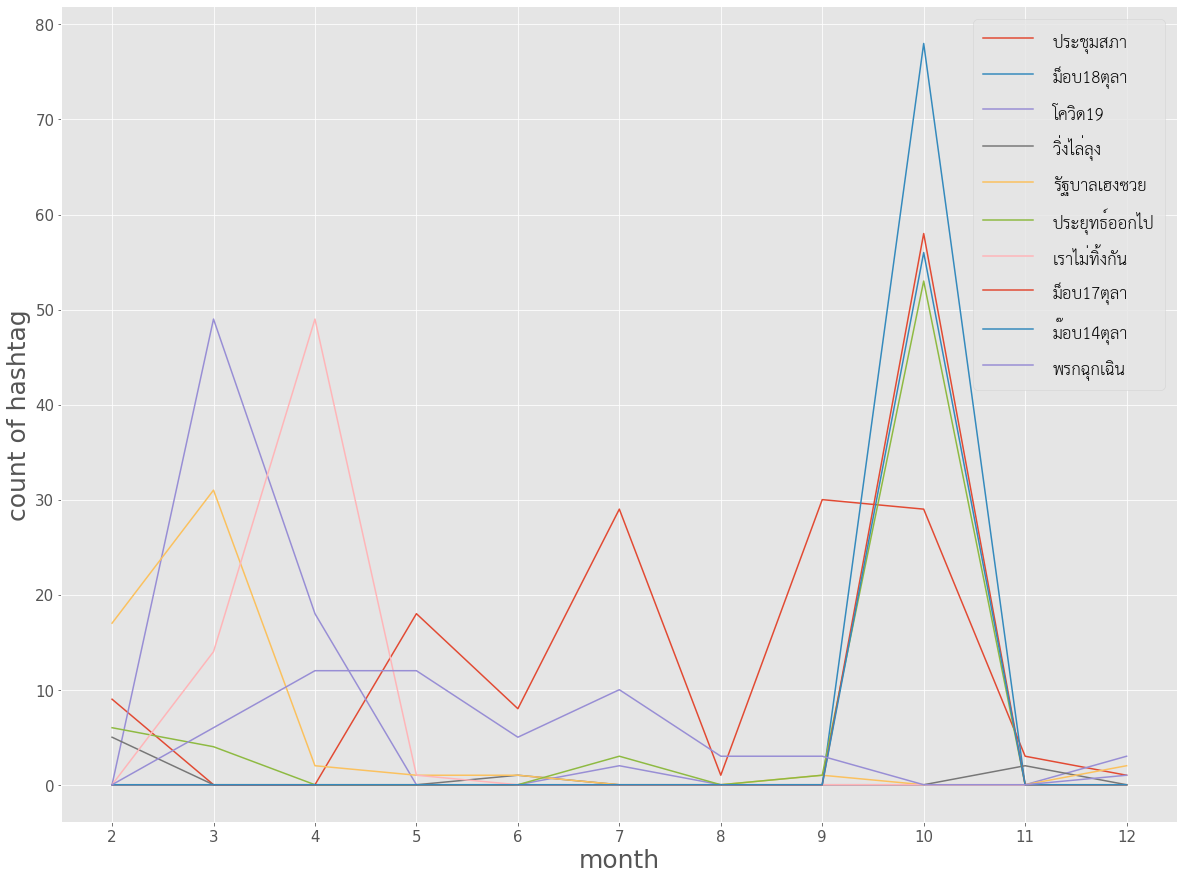

In [121]:
### plot time series ###

start_m = 2
xs = list(range(start_m, 13))

fig = plt.figure(figsize=(20,15))

for tag, count in hashtag_counter.most_common(10):
    counts = []  
    for m in range(start_m, 13):
        count = 0
        thismonth_df = df[df.date.dt.month == m]
        for i, row in thismonth_df.iterrows():
            if tag in row['hashtags']:
                count += 1
        counts.append(count)

    plt.plot(xs, counts, label=tag)

plt.xticks(xs, size=15)
plt.yticks(size=15)
plt.legend(prop=font_label)
plt.xlabel('month', size=25)
plt.ylabel('count of hashtag', size=25)
plt.show()

# LDA

In [122]:
%%time

num_topic = 5

corpus_dictionary = Dictionary(df.tokens)
corpus = []
for tokens_list in tqdm(df.tokens):
    corpus.append(corpus_dictionary.doc2bow(tokens_list))
lda = LdaModel(corpus, num_topics=num_topic, id2word=corpus_dictionary, passes=10)

100%|██████████| 2889/2889 [00:00<00:00, 34356.05it/s]


CPU times: user 23.2 s, sys: 172 ms, total: 23.4 s
Wall time: 23.7 s


In [123]:
### print result of keywords ###
print('|rank|topic 1||topic 2||topic 3||topic 4||topic 5||\n|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|')
for i in range(10):
    print(f'|{i+1}', end='')
    for j in range(5):
        word, score = lda.show_topic(j)[i]
        print(f"|{word}|{score:.3f}",end="")
    print('|')

|rank|topic 1||topic 2||topic 3||topic 4||topic 5||
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
|1|ประชาชน|0.013|ประชาชน|0.037|รัฐบาล|0.035|ม็อบ|0.016|ม็อบ|0.029|
|2|คน|0.011|คน|0.026|คน|0.016|น.|0.012|ตุลา|0.028|
|3|ตาย|0.010|รัฐบาล|0.017|โควิด|0.014|ม.|0.011|คน|0.018|
|4|ทำ|0.009|ล้าน|0.015|สภา|0.013|ลุง|0.009|ชุมนุม|0.015|
|5|อนาคต|0.009|รัฐ|0.013|ประชาชน|0.013|พฤศจิกา|0.008|ลุง|0.011|
|6|รัฐบาล|0.009|เงิน|0.012|ประเทศ|0.012|เผด็จการ|0.008|ประชาชน|0.011|
|7|ฝุ่น|0.008|ทิ้ง|0.011|ไทย|0.011|ลาน|0.008|ตำรวจ|0.010|
|8|ประเทศ|0.007|โควิด|0.011|ประยุทธ์|0.009|พลัง|0.008|วิ่งไล่|0.010|
|9|นายก|0.007|ทำ|0.010|ฉุกเฉิน|0.008|เวลา|0.008|ประยุทธ์|0.009|
|10|อย่า|0.007|ประยุทธ์|0.009|เฮงซวย|0.008|ค่า|0.007|ประกาศ|0.007|


In [124]:
### prediction - argmax ###

n = len(df)

result_matrix = np.zeros((n, num_topic))
for row, dist in enumerate(lda.get_document_topics(corpus[:n])):
    for tpl in dist:
        col = tpl[0]
        result_matrix[row,col] = tpl[1]
        
result_df = pd.DataFrame(result_matrix)
result_df['topic'] = result_df.apply(lambda row: np.argmax(row), axis=1)
result_df['tweet'] = df.tweet.reset_index(drop=True)
result_df['date'] = df.apply(lambda row: get_hour(row), axis=1).reset_index(drop=True)

result_df

,0,1,2,3,4,topic,tweet,date
0,0.000000,0.250363,0.089732,0.000000,0.646742,4,จับ #ม๊อบย่างกุ้ง แต่ไม่จับบ่อน จับม็อบอ้างทำ...,2020-12-31 16:00
1,0.040071,0.040061,0.040061,0.040090,0.839717,4,ตำรวจหรือนักเลง ? #ม๊อบย่างกุ้ง https://t.c...,2020-12-31 13:00
2,0.200000,0.200000,0.200000,0.200000,0.200000,0,555555555555555555555 https://t.co/NJeMAgx2qi,2020-12-30 04:00
3,0.000000,0.073660,0.222390,0.691217,0.000000,3,สาธารณสุข บอกขอคนไทยงดเดินทางข้ามจังหวัด ช่วงป...,2020-12-29 23:00
4,0.014407,0.014437,0.263518,0.014302,0.693336,4,ด่วน ! ประยุทธ์ออกข้อกำหนด #ห้ามชุมนุม ตามข้อก...,2020-12-26 00:00
...,...,...,...,...,...,...,...,...
2884,0.018499,0.018455,0.468308,0.018629,0.476110,4,ใบอนุญาตให้ใช้สวนรถไฟไม่หายแน่นอนครับ เอาใส่กร...,2020-01-05 19:00
2885,0.033339,0.033338,0.033445,0.865394,0.034484,3,วิ่งหรือนิ่ง 12 มกราคม 2563 #วิ่งไล่ลุง https...,2020-01-04 12:00
2886,0.959518,0.010130,0.010154,0.010139,0.010058,0,พิธีกร : ถ้าคุณไปสิงร่างคนอื่นได้ คุณจะไปสิงร่...,2020-01-02 12:00
2887,0.910424,0.022497,0.022407,0.022275,0.022396,0,อยากทำสิ่งใหม่ๆ ที่มีค่าเหรอครับ เซ็นใบลาออกสิ...,2020-01-01 13:00


In [125]:
### print prediction ###

print('|tweet|topic|prob of 1|2|3|4|5|\n|:-:|:-:|:-:|:-:|:-:|:-:|:-:|')
for i, row in result_df[['tweet','topic',0,1,2,3,4]].sample(10).iterrows():
    print(f'|{row.tweet}|{row.topic+1}|{row[0]:.3f}|{row[1]:.3f}|{row[2]:.3f}|{row[3]:.3f}|{row[4]:.3f}|')

|tweet|topic|prob of 1|2|3|4|5|
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
|สรุป ประกาศ #พรกฉุกเฉินฯ พรุ่งนี้ ส่วนมาตรการให้รอฟังอีกที   จบ สวัสดี  #งบกลางหายไปไหน|3|0.014|0.014|0.642|0.013|0.317|
|สรุป เพื่อไทยมีมติให้เสนอญัตติแก้ไขรัฐธรรมนูญรายมาตราเพิ่มเติม คือ ยกเลิกอำนาจ ส.ว. โหวตเลือกนายก พ่วงแก้ไขที่มานายก ให้มีที่มาจาก ส.ส. และบัญชีแคนดิเดตนายกที่พรรคการเมืองเสนอต่อ กกต. เท่านั้น ปิดทางนายกคนนอก  และเสนอแก้ระบบเลือกตั้ง ให้กลับไปใช้บัตร 2 ใบ  #ไม่เอารัฐบาลแห่งชาติ  https://t.co/4SXrwX3vZ7|1|0.472|0.117|0.400|0.000|0.000|
|ขยี้ตาอ่านหลายรอบมาก  https://t.co/xZXEPOKjUc|3|0.051|0.050|0.798|0.050|0.050|
|การวิจารณ์ระบอบลุง คือ ความหวังดีที่เราอยากเห็นประเทศพัฒนากว่าที่เป็นอยู่ ประเทศเรามีศักยภาพ แต่มีลุงอยู่กลุ่มนึงทำให้มันพัฒนาได้ไม่เต็มที่  ในเมื่อมันสามารถดีได้กว่านี้ ทำไมเราถึงต้องจมปลักอยู่กับลุง การเรียกร้องให้ลุงออกไป เพื่อให้ประเทศดีกว่าเดิม   เราผิดตรงไหนครับ ?|4|0.000|0.000|0.388|0.586|0.000|
|รัฐบาลบอกว่าถังไม่แตก แต่ไม่มีเงินจ่ายเบี้ยยังชีพผู้สูงอายุและเบี้ยความพิการแล้วครับ มีรัฐบา

In [ ]:
### plot topic time series ###

tempdf = timerange(df)

for t in range(5):
    tempdf[t+1] = tempdf.date.apply(lambda x: sum((result_df.date <= x) & (result_df.topic==t)))
    
tempdf.plot(x='date', figsize=(20,15))
plt.legend(prop=font_label)
plt.ylabel('cumulative count', size=20)
plt.xlabel('datetime', size=20)
plt.xticks(rotation=40, size=15)
plt.yscale('log')
plt.show()